## Изучение данных

Исходные данные: интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В наличии данные до 2016 года, планируется кампания на 2017-й. Нужно отработать принцип работы с данными. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import norm

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/Users/79833/Desktop/Data/4 prefabricated project/games.csv')

In [3]:
display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:**

В исходном датафрейме 'data' 16715 строк и 11 колонок, содержащих информацию о:
- названии игры, 
- платформе, 
- годе релиза, 
- жанре, 
- рейтинге игры в Северной Америке, Европе, Японии, а также других странах,
- оценке критиков,
- оценке игроков,
- возрастном рейтинге игры.

## Предобработка данных

Для начала приведу названия столбцов к нижнему регистру:

In [5]:
data.columns = data.columns.str.lower()

Переименую столбец 'year_of_release' просто в 'year' для удобства:

In [6]:
data.rename(columns={ data.columns[2]: "year" }, inplace = True)

In [7]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0.010000
platform,0.000000
year,1.610000
genre,0.010000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.320000
user_score,40.090000


Посколько пропуски в колонке 'name' составляют менее 1% от всего объема данных, удалю строки с пропущенными значениями:

In [8]:
data = data.dropna(subset = ['name']).reset_index(drop = True)

Аналогично поступлю с пропусками в колонке 'year':

In [9]:
data = data.dropna(subset = ['year']).reset_index(drop = True)

Посмотрю еще раз какие пропуски остались:

In [10]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.450000
user_score,40.170000


Посмотрю подробнее информацию **о колонках с рейтингом и оценками**:

In [11]:
data['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [12]:
data['user_score'].describe()

count     9839
unique      96
top        tbd
freq      2376
Name: user_score, dtype: object

In [13]:
data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.6       2
1.1       2
0.2       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

В 'user_score' помимо числовых значений присутствует 'tbd', из-за чего данная колонка имеет тип object. TBD -  to be determined, т.е. предстоит определить.


Чтобы колонка могла принадлежать к типу 'float', необходимо обработать значения 'tbd'. По сути, это те же самые пропуски, поэтому заменю 'tbd' на NaN и приведу колонку 'user_score' к типу 'float':

In [14]:
print('Количество пропусков в колонке "user_score" до обработки:', data['user_score'].isnull().sum())

Количество пропусков в колонке "user_score" до обработки: 6605


In [15]:
data.loc[data['user_score'] == "tbd", 'user_score'] = np.nan

In [16]:
data['user_score'] = data['user_score'].astype('float')

In [17]:
print('Количество пропусков в колонке "user_score" после обработки:', data['user_score'].isnull().sum())

Количество пропусков в колонке "user_score" после обработки: 8981


In [18]:
data['rating'].describe()

count     9768
unique       8
top          E
freq      3921
Name: rating, dtype: object

In [19]:
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Колонка 'rating' содержит малопонятные обозначения рейтинга от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
С помощью официального сайта вышеуказанной организации заменю краткие обозначения категорий на полные:

In [20]:
def ESRB(row):
    if row == 'E':
        return 'Everyone'
    if row == 'T':
        return 'Teen'
    if row =='M':
        return 'Mature'
    if row == 'E10+':
        return 'Everyone 10 and older'
    if row == 'EC':
        return 'Early childhood'
    if row == 'K-A':
        return 'Early childhood'
    if row == 'RP':
        return 'Rating Pending'
    if row == 'AO':
        return 'Adults Only 18+'
    return row

data['rating'] = data['rating'].apply(ESRB)

Приведу колонку **'year'** к типу данных 'int'. 

Колонки 'na_sales', 'eu_sales', 'jp_sales', 'other_sales' оставлю без изменений, т.к. данные в них представлены в миллионах и приведение к 'int' исказит данные.

In [21]:
data['year'] = data['year'].astype('int')

Таким образом, **пропуски** остались в следующих колонках:
- critic_score	
- user_score
- rating

Проверю какой процент  игр не имеет оценки с группировкой по годам:

In [22]:
data.loc[data['critic_score'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16440,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16442,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


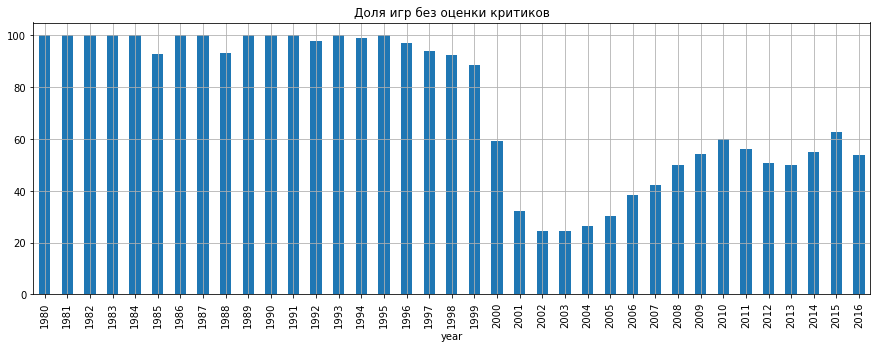

In [23]:
aa = data.loc[data['critic_score'].isna()].groupby('year')['name'].count()/data.groupby('year')['name'].count()*100
aa.plot(y='name',
        kind='bar',
        figsize=(15,5),
        grid = True,
        title = 'Доля игр без оценки критиков');

С 1980 по 1995 гг. количество игр без оценки критиков достигает практически 100%, но потом снижается до отметки приблизительно 27% в 2002 году, однако после этого снова увеличивается, достигая максимума в 2015 г.

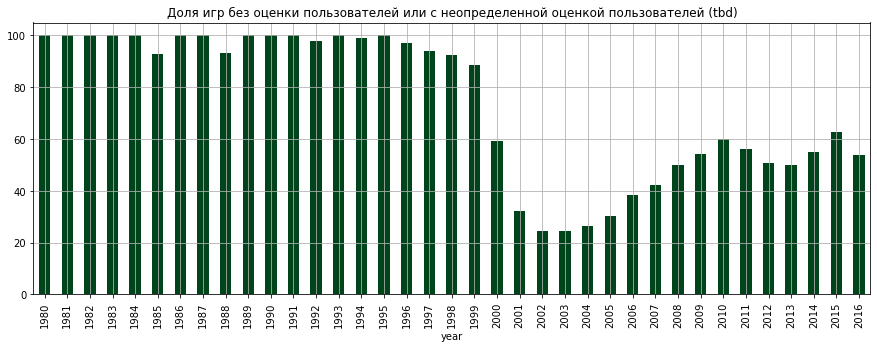

In [24]:
bb = data.loc[(data['critic_score'].isna())|(data['user_score']== "tbd")].groupby('year')['name'].count()/data.groupby('year')['name'].count()*100
bb.plot(y='name',
         kind='bar',
         figsize=(15,5),
         grid = True,
         title = 'Доля игр без оценки пользователей или с неопределенной оценкой пользователей (tbd)',
         cmap = 'Greens_r');

Аналогичная ситуация с оценками пользователей: практически 100% пропущенных или неопределенных значений в 1980-1995 гг.

Можно сделать предварительный вывод, что данные до 2000 г. вообще исследоваться не будут, т.к. являются неинформативными. Поэтому сразу очищу датафрейм от данных старше 2000 г.:

In [25]:
data = data.drop(data[data.year<2000].index).reset_index(drop = True)

Так как в исследовательском анализе необходимо будет использовать оценки пользователей и критиков, необходимо обработать пропуски. Заменить их на медиану или среднее будет некорректно, т.к. данные показатели не коррелируются ни с чем.
В таком случае оставлю пропуски без изменений. 

Проверю **количество пропусков после обработки**:

In [26]:
data.isnull().sum()

name               0
platform           0
year               0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    6583
user_score      7099
rating          4807
dtype: int64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14470 entries, 0 to 14469
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          14470 non-null  object 
 1   platform      14470 non-null  object 
 2   year          14470 non-null  int32  
 3   genre         14470 non-null  object 
 4   na_sales      14470 non-null  float64
 5   eu_sales      14470 non-null  float64
 6   jp_sales      14470 non-null  float64
 7   other_sales   14470 non-null  float64
 8   critic_score  7887 non-null   float64
 9   user_score    7371 non-null   float64
 10  rating        9663 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.2+ MB


Датафрейм 'data' выглядит следующим образом:

In [28]:
display(data.head(10))

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,Everyone
1,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,Everyone
2,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,Everyone
3,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,Everyone
4,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,Everyone
5,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,Everyone
6,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
7,Mario Kart DS,DS,2005,Racing,9.71,7.47,4.13,1.90,91.0,8.6,Everyone
8,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.0,7.7,Everyone
9,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,Everyone


**Вывод:**

В данном разделе была выполнена предобработка данных в виде:
- приведения названий столбцов к нижнему регистру;
- переименовка столбца 'year_of_release' в 'year';
- проанализированы и обработаны пропущенные значения;
- подробно просмотрена информация по каждой колонке датафрейма;
- заменены малопонятные обозначения в колонке 'rating';
- колонка 'year' приведена к типу 'int';
- значения 'tbd' в колонке 'user_score' были заменены на NaN, т.к. ранееуказанное значение помешает дальнейшему анализу;
- колонка 'user_score' приведена к типу 'float'.


В аспекте обработки пропусков было выполнено дополнительное иссделование, которое показало что с 1980 по 1995 год практически 100% игр не имеют оценки и рейтинга. В 2000 году их доля снижается до ~60% и достигает минимума в 2002 году (около 27%). С 2008 по 2016 гг. пропущенные значения занимают приблизительно половину от общего массива данных. Поэтому данные до 2000 г. были исключены из обработки.  Поскольку в анализе будет проводиться исследование влияние оценок пользователей и критиков, необходимо обработать пропуски. Так как оценки у всех игр индивидуальные и не зависят от жанра или игровой платформы, заменить их не получится, поэтому пропуски оставлены без изменения. 

## Исследовательский анализ данных

### Время выхода игр

Посмотрю сколько игр выпускалось в разные годы путем группировки по году, с подсчетом количества игр:

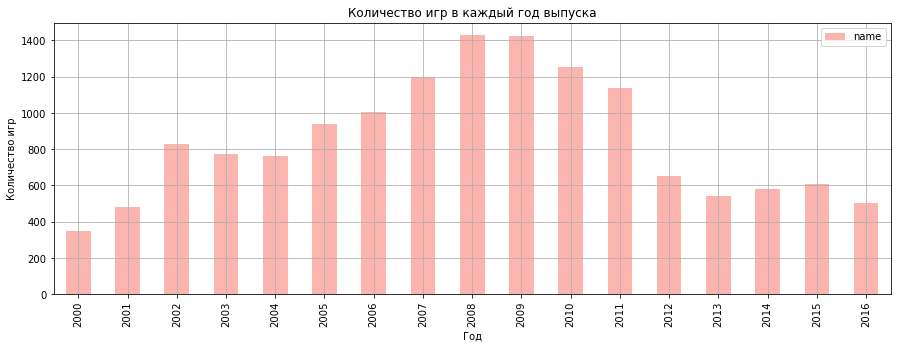

In [29]:
data_years_grouped = data.pivot_table(index = 'year', 
                 values = 'name', 
                 aggfunc = 'count')
data_years_grouped.plot(y = 'name', 
                        figsize = (15, 5),
                        kind = 'bar', 
                        grid = True, 
                        cmap = 'Pastel1', 
                        title = 'Количество игр в каждый год выпуска')
plt.ylabel('Количество игр')
plt.xlabel('Год');

Спад количества игр с 2010 года можно связать с ростом популярности игр на смартфонах.

### Платформы

Для анализа **продаж по платформам** добавлю новую колонку 'total_sales', которая будет включать в себя сумму продаж во всех регионах:

In [30]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

В датафрейме 'data_total_sales' сгруппирую данные по платформам и посмотрю, сколько миллионов копий было продано по каждой:

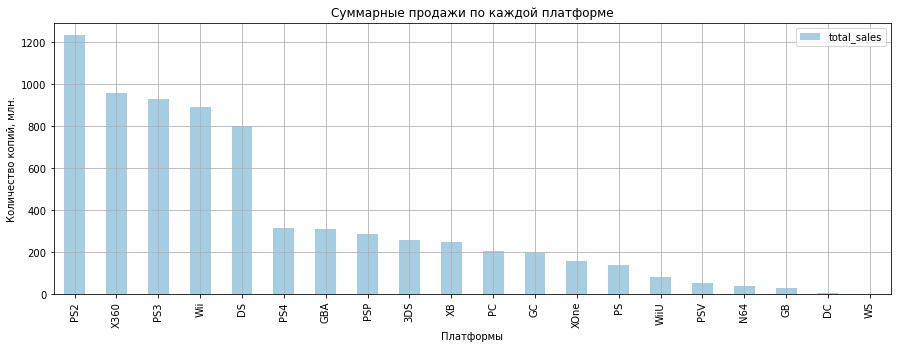

In [31]:
data_total_sales = data.pivot_table(index = 'platform', 
                 values = 'total_sales', 
                 aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
data_total_sales.plot(y = 'total_sales', 
                      figsize = (15, 5),
                      kind = 'bar', 
                      grid = True,
                      cmap = 'Paired',
                      title = 'Суммарные продажи по каждой платформе')
plt.ylabel('Количество копий, млн.')
plt.xlabel('Платформы');

Далее посмотрю распределение глобального количество проданных копий по каждой платформе в зависимости от года:

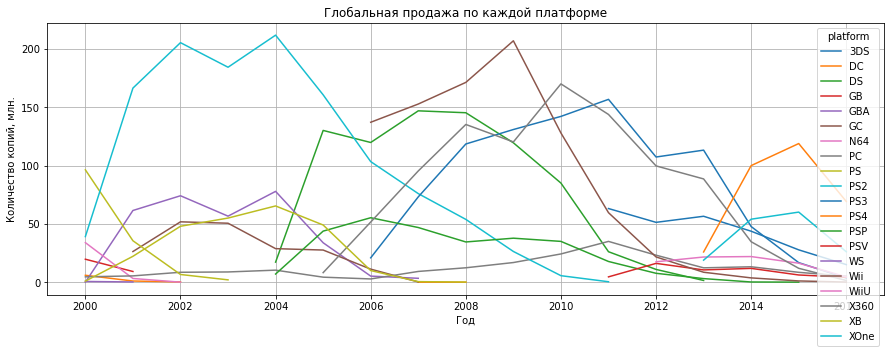

In [32]:
data.pivot_table(index = 'year', 
                 values = 'total_sales', 
                 columns = 'platform', 
                 aggfunc = 'sum').reset_index().plot(x = 'year', 
                                                     figsize = (15,5), 
                                                     grid = True, 
                                                     title = 'Глобальная продажа по каждой платформе')
plt.ylabel('Количество копий, млн.')
plt.xlabel('Год');

Можно сказать, что **приблизительный "срок жизни" платформы 7 лет**. Однако платформа PC (персональный компьютер) не устаревает.

На графике можно увидеть, что у большинства платформ "срок жизни" заканчивается еще к 2010 г., поэтому можно было бы взять данные с 2010 г., но также видно, что платформы PSP, DS и Wii "умирают" в 2012 г., поэтому лучше взять данные с 2013 г., это и будет являться **актуальным периодом**

Создам новый датафрейм 'data_2013', в который отсортирую только данные не старше 2013 года:

In [33]:
data_2013 = data.drop(data[data.year<2013].index).reset_index(drop = True)

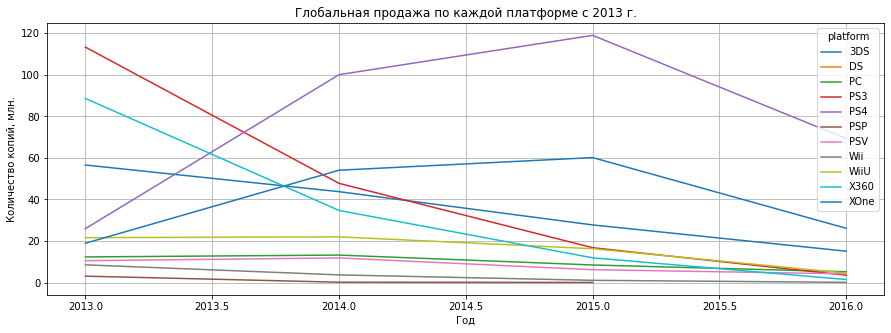

In [34]:
data_2013.pivot_table(index = 'year', 
                 values = 'total_sales', 
                 columns = 'platform', 
                 aggfunc = 'sum').reset_index().plot(x = 'year', 
                                                     figsize = (15,5), 
                                                     grid = True, 
                                                     title = 'Глобальная продажа по каждой платформе с 2013 г.')
plt.ylabel('Количество копий, млн.')
plt.xlabel('Год');

Построю диаграмму для визуализации распределения глобальных продаж, чтобы понять какие платформы являются наиболее прибыльными:

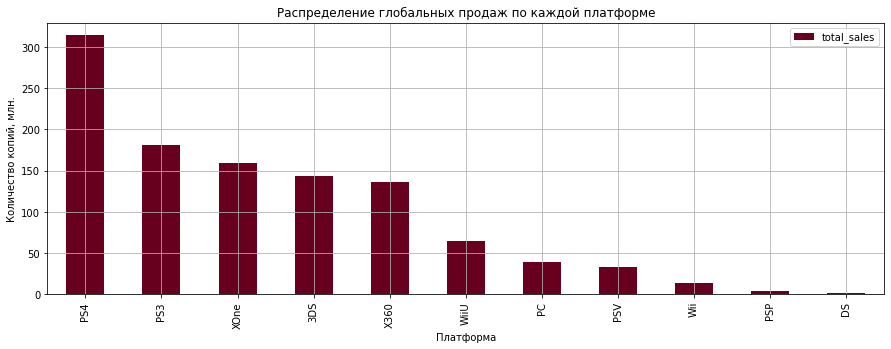

In [35]:
top_platform = data_2013.pivot_table(index = 'platform', 
                 values = 'total_sales', 
                 aggfunc = 'sum').sort_values(by = 'total_sales', 
                                              ascending = False)
top_platform.plot(y='total_sales', 
                  figsize = (15,5),
                  grid = True,
                  kind = 'bar', 
                  cmap = 'PuRd_r', 
                  title = 'Распределение глобальных продаж по каждой платформе')
plt.ylabel('Количество копий, млн.')
plt.xlabel('Платформа');

Можно сделать вывод, что **лидирующей платформой** является PS4 с более чем 300 млн. проданных копий. На 2м месте находится PS3  с ~180 млн. копий, 3е - у платформы XOne с 160 млн. Замыкают топ-5 платформы 3DS и X360 со 143 млн. и 135 млн. копий соответственно.

Далее построю график **«ящик с усами»**, с помощью метода boxplot, по глобальным продажам игр в разбивке по наиболее популярным платформам:
- PS4;
- PS3;
- XOne;
- 3DS;
- X360.

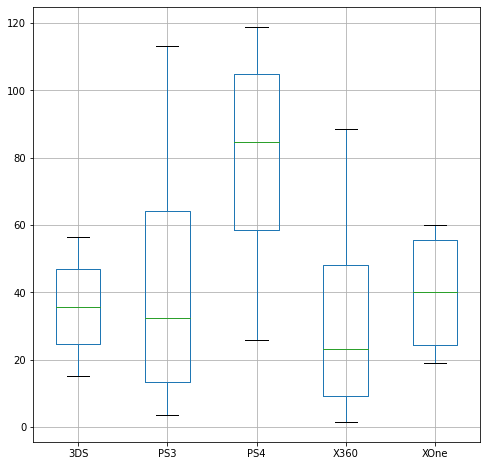

In [36]:
cc = data_2013.loc[(data_2013['platform'] == "PS4")+(data_2013['platform'] == "PS3")+(data_2013['platform'] == "XOne")+(data_2013['platform'] == "3DS")+(data_2013['platform'] == "X360")]
cc.pivot_table(index = 'year', 
                 values = 'total_sales', 
                 columns = 'platform', 
                 aggfunc = 'sum').boxplot(figsize=(8,8));

Из всех вышепредставленных на графике платформ, у 3DS и XOne можно заметить нормальное распределение значений: медиана находится посередине, "усы" равноудалены от границ "ящика". Это значит что у данных платформ равномерное распределение продаж игр по годам. 
    
По остальным платформам наблюдается ассиметрия данных.
    
У лидирующей платформы - PS4 "ящик" немного смещен к максимальному значению, это означает, что половина значений глобальных продаж находятся в промежутке между 25 и 85 млн. копий и оставшиеся 50% между 85 и почти 120 млн.  
По платформе PS3 противоположная ситуация: половина значений глобальных продаж не достигает отметки 35 млн. копий, в оставшуюся половину входит набор значений от 35 до ~117 млн., что говорит об очень неравномерных продажах игр, выпускаемых на данной платформе.
    
Так как РС занимает последнее место по распределению глобальных продаж, "ящик с усами" также получился небольшим. Можно сказать, что минимальное и максимальное значения находятся недалеко друг от друга, примерно на отметках 5 и 12 млн. копий соответственно. Медиана немного смещена в сторону третьего квантиля. По платформе X360 также можно сделать вывод о смещении медианы в сторону меньших значений. Первые 25% глобальных продаж находятся на интервале от 10 до 25 млн, соответственно, медиана проходит на отметке приблизительно в 25 млн. копий, последние 25% - в интервале от 25 до 70 млн. При этом максимальное значение составляет 90 млн. копий.
    
В целом, по платформам PS3 и X360 иможно сделать вывод, что значения глобальных продаж игр, вышедших на данных платформах, распределены очень неравномерно.

Такие различия между платформами могут быть связаны с неравномерной стоимостью игр, выпускаемых на данных платформах, либо с увеличением количества их производства.Также можно отметить, что у платформ 3DS, PS3, X360 и Xone медиана глобальных продаж проходит в интервале между 25 и 40 млн. копий, в то же время у PS4 медиана проходит на отметке приблизительно 95 млн. копий. Отсюда можно сделать вывод, что в целом игры на данной платформе продаются лучшe

Далее посмотрю, **как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков**. Начну с "лидирующей" PS4:

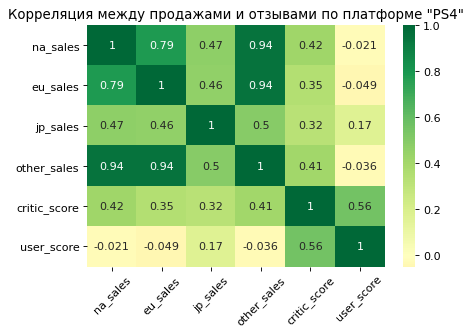

In [37]:
plt.figure(figsize=(6,4), dpi= 80)
sns.heatmap(data_2013.loc[(data_2013['platform'] == "PS4"), ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].corr(), cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция между продажами и отзывами по платформе "PS4"')
plt.xticks(rotation=45)
plt.show()

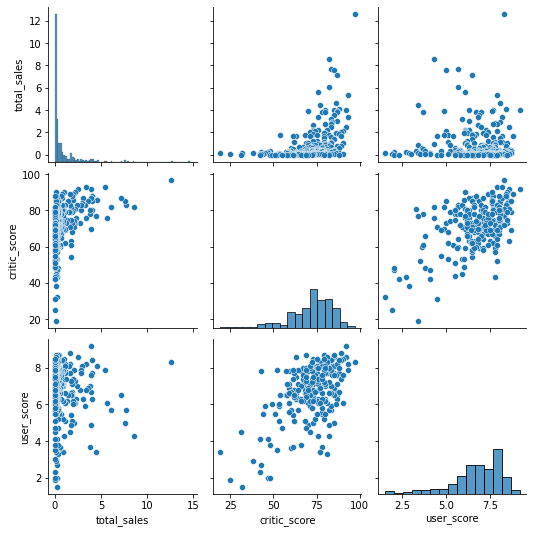

In [38]:
sns.pairplot(data_2013.loc[(data_2013['platform'] == "PS4"), ['total_sales', 'critic_score', 'user_score']], kind="scatter")
plt.show()

Наибольшая корреляция наблюдается между 'other_sales', 'na_sales' и 'eu_sales' - выше 0.7 что означает, что в целом продажи в Северной Америке, Европе и прочих странах (кроме Японии) по каждой игре пропорциональны, что может говорить о схожести вкусов игроков в данных регионах. 'jp_sales' коррелирует с остальными значениями продаж в среднем на 54%, что говорит о среднем влиянии. 
Также можно сказать, что на оценки пользователей не влияют практически никакие значения, кроме оценок критиков. В данном случае наблюдается корреляция 57%.  
Оценки критиков, в свою очередь, коррелируют на 41% со значениями по продажам в Северной Америке и в других странах и на 32 и 34% соответственно со значениями продаж в Японии и Европе. 

Далее проанализирую остальные платформы:

**'PS3'**

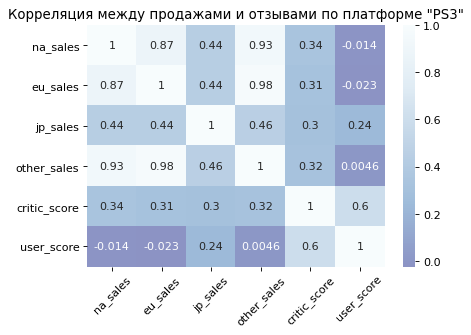

In [39]:
plt.figure(figsize=(6,4), dpi= 80)
sns.heatmap(data_2013.loc[(data_2013['platform'] == "PS3"), ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].corr(), cmap='BuPu_r', center=0, annot=True)

plt.title('Корреляция между продажами и отзывами по платформе "PS3"')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x640 with 0 Axes>

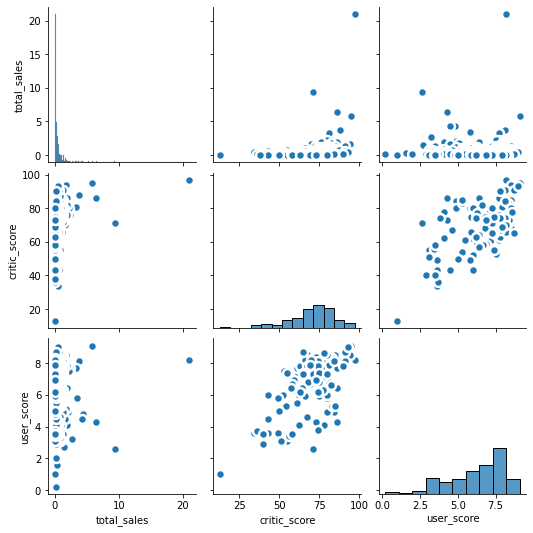

In [40]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(data_2013.loc[(data_2013['platform'] == "PS3"), ['total_sales', 'critic_score', 'user_score']], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

**'XOne'**

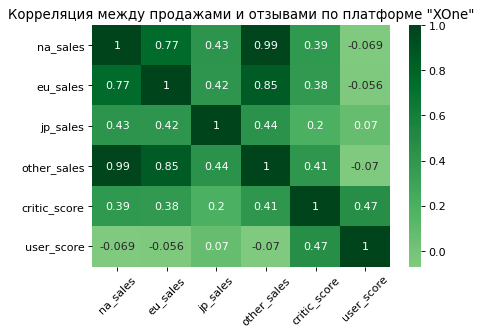

In [41]:
plt.figure(figsize=(6,4), dpi= 80)
sns.heatmap(data_2013.loc[(data_2013['platform'] == "XOne"), ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].corr(), cmap='Greens', center=0, annot=True)

plt.title('Корреляция между продажами и отзывами по платформе "XOne"')
plt.xticks(rotation=45)
plt.show()

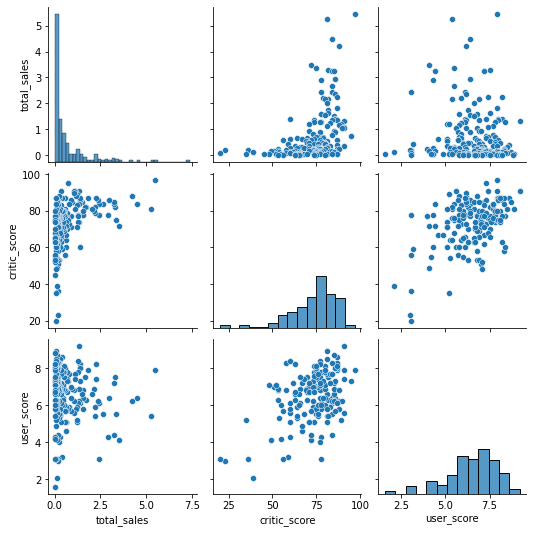

In [42]:
sns.pairplot(data_2013.loc[(data_2013['platform'] == "XOne"), ['total_sales', 'critic_score', 'user_score']], kind="scatter")
plt.show()

**'3DS'**

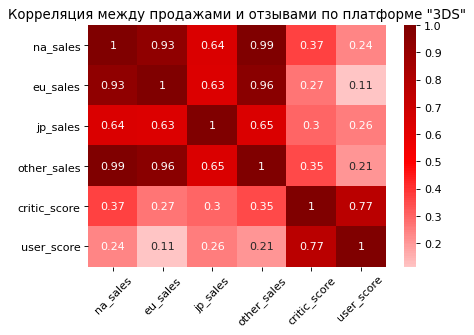

In [43]:
plt.figure(figsize=(6,4), dpi= 80)
sns.heatmap(data_2013.loc[(data_2013['platform'] == "3DS"), ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].corr(), cmap='seismic', center=0, annot=True)

plt.title('Корреляция между продажами и отзывами по платформе "3DS"')
plt.xticks(rotation=45)
plt.show()

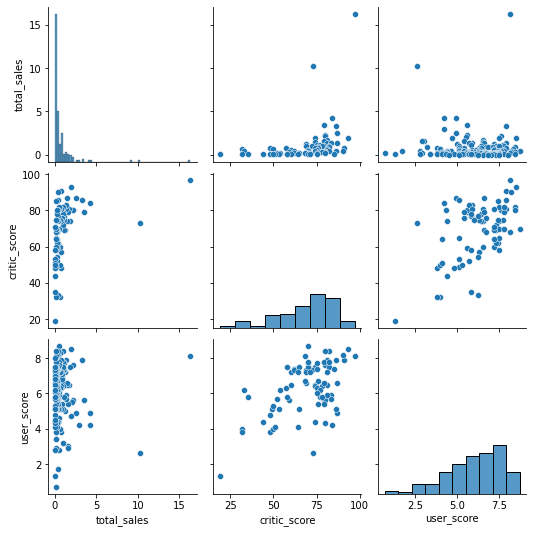

In [44]:
sns.pairplot(data_2013.loc[(data_2013['platform'] == "X360"), ['total_sales', 'critic_score', 'user_score']], kind="scatter")
plt.show()

**'X360'**

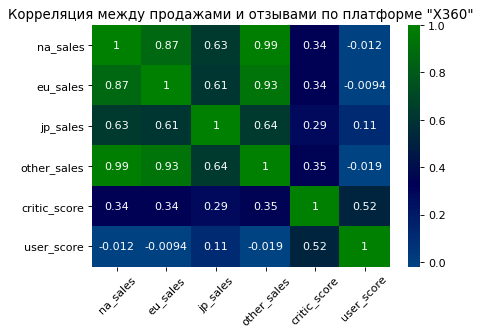

In [45]:
plt.figure(figsize=(6,4), dpi= 80)
sns.heatmap(data_2013.loc[(data_2013['platform'] == "X360"), ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].corr(), cmap='ocean_r', center=0, annot=True)

plt.title('Корреляция между продажами и отзывами по платформе "X360"')
plt.xticks(rotation=45)
plt.show()

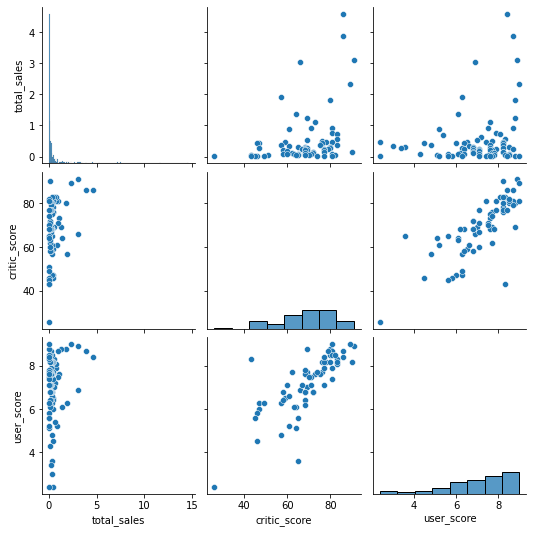

In [46]:
sns.pairplot(data_2013.loc[(data_2013['platform'] == "3DS"), ['total_sales', 'critic_score', 'user_score']], kind="scatter")
plt.show()

В целом по всем платформам наблюдается ситуация, аналогичная PS4. 

### Жанры

Далее исследую общее распределение игр по жанрам:

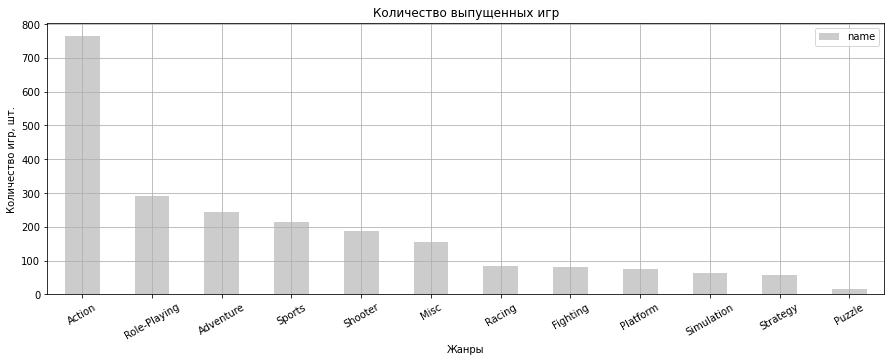

In [47]:
data_2013.pivot_table(index = 'genre', 
                 values = 'name', 
                 aggfunc = 'count').sort_values(by = 'name', ascending = False).plot(y = 'name',
                                                                                           figsize = (15, 5),
                                                                                           kind = 'bar',
                                                                                           grid = True,
                                                                                           cmap = 'Pastel2_r')

plt.xlabel('Жанры')
plt.ylabel('Количество игр, шт.')
plt.title('Количество выпущенных игр')
plt.xticks(rotation=30);

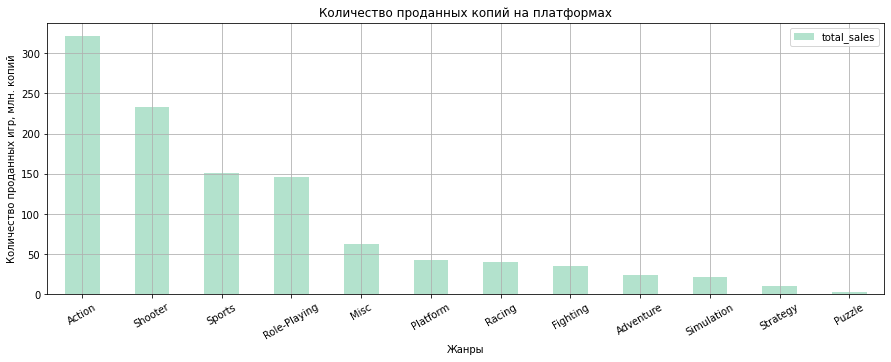

In [48]:
data_2013.pivot_table(index = 'genre', 
                 values = 'total_sales', 
                 aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False).plot(y = 'total_sales',
                                                                                          figsize = (15, 5),
                                                                                          kind = 'bar',
                                                                                          grid = True,
                                                                                          cmap = 'Pastel2')

plt.xlabel('Жанры')
plt.ylabel('Количество проданных игр, млн. копий')
plt.title('Количество проданных копий на платформах')
plt.xticks(rotation=30);

Можно сделать вывод, что жанр Action является наиболее популярным и прибыльным. Это жанр компьютерных игр, в котором делается упор на эксплуатацию физических возможностей игрока, в том числе координации глаз и рук и скорости реакции. Также в топ-3 популярных жанров входят Shooter и Sports ("стрелялки" и спортивные игры). Самым неприбыльным жанром оказался Pazzle.

**Вывод:**

В данном разделе было проанализировано время выхода игр, на каких платформах они выходят и в каких жанрах.

 В ходе исследования было выявлено, что вплоть до 2000 г. выпускалось менее 200 игр в год. На основе данного результата дальнейший анализ строился от 2001 г.

Для анализа продаж по платформам была создана колонка 'total_sales', объединяющая в себе все значения продаж по регионам. В результате группировки данных по глобальным продажам в разрезе платформ было выявлено, что большинство платформ не достигают отметки даже в 200 млн. копий. Поэтому для дальнейшего исследования были взяты платформы, у которых сумма глобальных продаж больше 150 млн. копий. 

Для выделения актуального периода анализа данных была выполнена группировка данных по размеру глобальных продаж за каждый год в разрезе платформ. Вышеуказанные данные можно увидеть на графике "Глобальная продажа по каждой платформе". Все платформы имеют некоторый "срок жизни" от появления на рынке до полного устаревания и вытеснения более новыми разработками. Судя по графику, этот период составляет приблизительно 7-8 лет. Из всех платформ выделяется РС, как не устаревающая, т.к. по сути персональные компьютеры постоянно модернизируются, но платформа остается прежней. Актуальный период не выбран с 2009 года по причине того, что такие платформы как DS и Wii ушли в 0 по продажам в 2012 году и строить прогноз с учетом этих платформ будет некорректно. Поэтому актуальный период был  выбран с 2013 года. Наиболее популярной платформой в данном временном отрезке оказалась PS4, имеющая более половины от распределения глобальных продаж. 

Наиболее популярным оказался жанр Action - около 170 млн. проданных копий и более 175 игр. Далее по популярности находится жанр Shooter с 115 млн. копий и около 90 выпущенных игр. Замыкает тройку жанр Sports, с ~85 млн. проданных копий и 70 играми. Самым непопулярным стал жанр Pazzle, в котором вышла всего 1 игра и менее миллиона проданных копий.

## Портрет пользователя каждого региона

В данном разделе построю портрет пользователя каждого региона: какие самые популярные платформы и жанры, а также посмотрю влияние рейтинга ESRB на продажи.

Tак как пропущенные значения в рейтинге игр были оставлены без изменения на этапе предобработки для сохранения полноты данных, на текущем этапе заменю их на значение "Без рейтинга" чтобы подробнее исследовать информацию:

In [49]:
data_2013['rating'] = data_2013['rating'].fillna('Без рейтинга')

In [50]:
data_2013['rating'].value_counts()

Без рейтинга             977
Mature                   369
Teen                     333
Everyone                 302
Everyone 10 and older    252
Name: rating, dtype: int64

In [51]:
print('Количество пропусков в колонке "rating" после обработки:', data_2013['rating'].isnull().sum())

Количество пропусков в колонке "rating" после обработки: 0


### Северная Америка

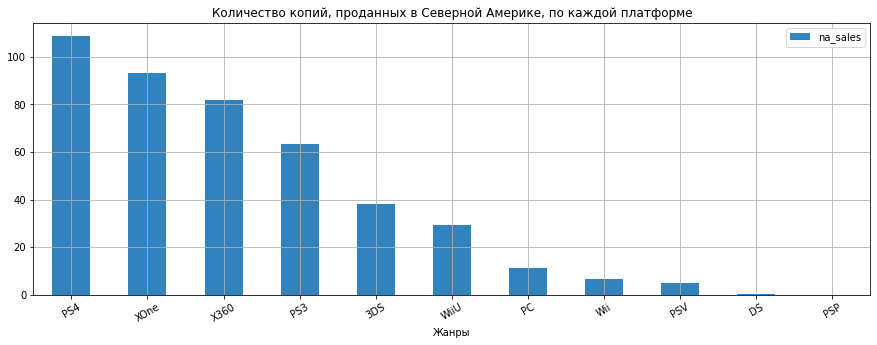

In [52]:
data_2013.pivot_table(index = 'platform', 
                 values = 'na_sales', 
                 aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False).plot(y = 'na_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'tab20c')

plt.xlabel('Жанры')
plt.title('Количество копий, проданных в Северной Америке, по каждой платформе')
plt.xticks(rotation=30);

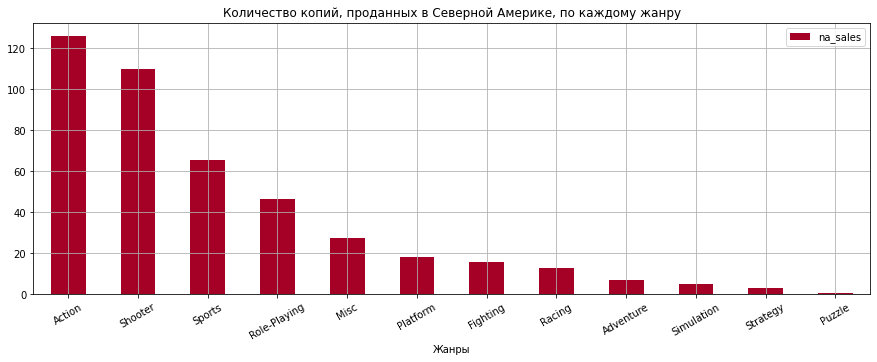

In [53]:
data_2013.pivot_table(index = 'genre', 
                 values = 'na_sales', 
                 aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False).plot(y = 'na_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'RdYlGn')

plt.xlabel('Жанры')
plt.title('Количество копий, проданных в Северной Америке, по каждому жанру')
plt.xticks(rotation=30);

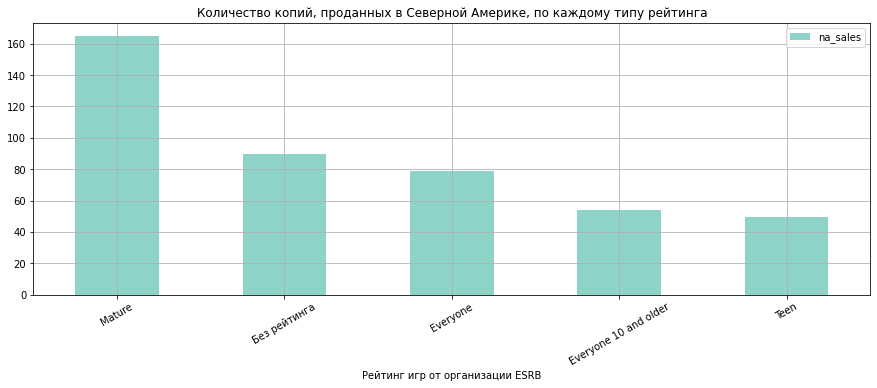

In [54]:
data_2013.pivot_table(index = 'rating', 
                 values = 'na_sales', 
                 aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False).plot(y = 'na_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'Set3')

plt.xlabel('Рейтинг игр от организации ESRB')
plt.title('Количество копий, проданных в Северной Америке, по каждому типу рейтинга')
plt.xticks(rotation=30);

In [55]:
data_2013.query('(rating == "Без рейтинга")&(na_sales>0)').sort_values(by = 'na_sales', ascending = False)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Без рейтинга,14.63
8,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,Без рейтинга,9.18
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Без рейтинга,14.60
14,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,Без рейтинга,7.39
5,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Без рейтинга,11.68
...,...,...,...,...,...,...,...,...,...,...,...,...
1477,Nobunaga's Ambition: Sphere of Influence - Sen...,PS4,2016,Misc,0.01,0.00,0.05,0.00,NaN,NaN,Без рейтинга,0.06
1208,Devil May Cry 4,PS4,2015,Action,0.01,0.00,0.08,0.00,NaN,NaN,Без рейтинга,0.09
1339,The Croods: Prehistoric Party!,Wii,2013,Misc,0.01,0.05,0.00,0.00,NaN,NaN,Без рейтинга,0.06
1203,Disney Planes Fire & Rescue,3DS,2014,Action,0.01,0.08,0.00,0.01,NaN,NaN,Без рейтинга,0.10


Игроки в Северной Америке предпочитают платформы PlayStation и Xbox: на первом месте PlayStation 4, на втором - XOne. Третье место у Xbox 360. 
Предпочитаемые жанры расположились аналогично общему исследованию: более продаваемый жанр Action, за ним Shooter и Sports. Наибольшую популярность имееют игры с рейтингом «Mature» — «Для взрослых»: материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории. Примерно равное количество проданных копий у игр **без рейтинга** и с рейтингом «Everyone» — «Для всех».
Таким образом, стандарный пользователь из Северной Америки играет на игровой консоли марки PlayStation или Xbox, предпочитает игры с боевыми действиями с рейтингом «Для взрослых».

Отдельно были рассмотрены игры "Без рейтинга" с количеством проданных копий отличным 0 млн. копий. Можно заметить, что в данную категорию попали игры разных жанров и на разных игровых платформах

Также можно отметить визуальное совпадение пропусков в колонках с оценками пользователей и критиков и с рейтингом. Возможно данная проблема связана просто с некачественными данными или потерей информации при выгрузке

### Европа

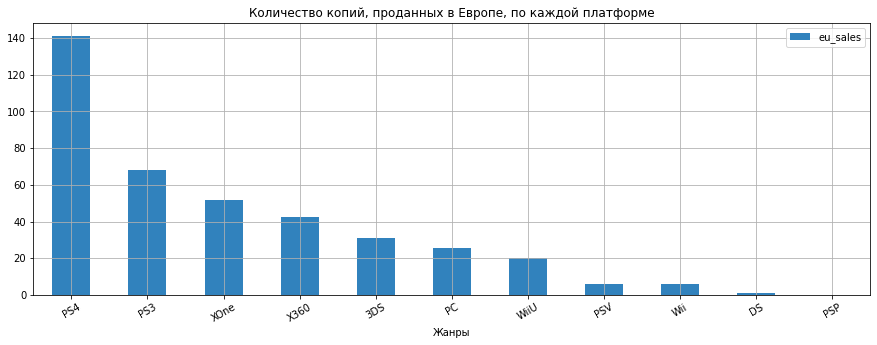

In [56]:
data_2013.pivot_table(index = 'platform', 
                 values = 'eu_sales', 
                 aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False).plot(y = 'eu_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'tab20c')

plt.xlabel('Жанры')
plt.title('Количество копий, проданных в Европе, по каждой платформе')
plt.xticks(rotation=30);

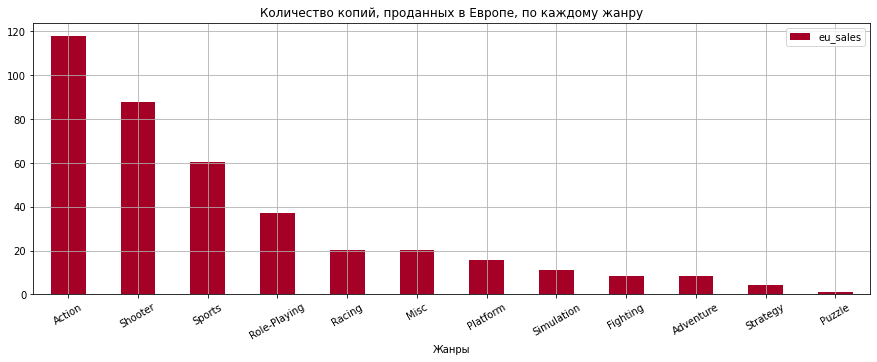

In [57]:
data_2013.pivot_table(index = 'genre', 
                 values = 'eu_sales', 
                 aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False).plot(y = 'eu_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'RdYlGn')

plt.xlabel('Жанры')
plt.title('Количество копий, проданных в Европе, по каждому жанру')
plt.xticks(rotation=30);

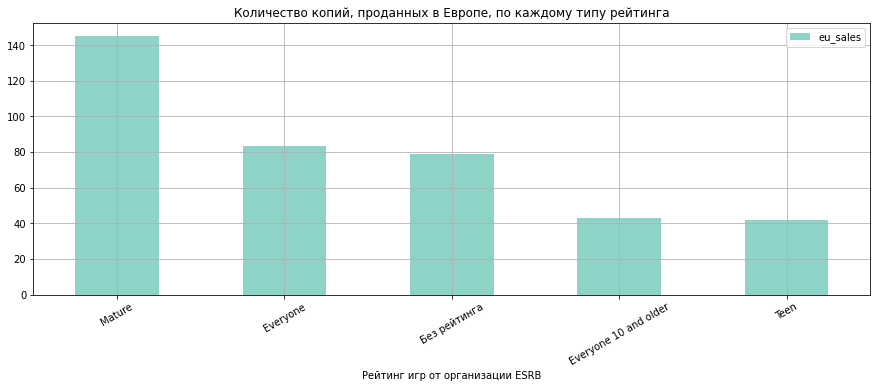

In [58]:
data_2013.pivot_table(index = 'rating', 
                 values = 'eu_sales', 
                 aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False).plot(y = 'eu_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'Set3')

plt.xlabel('Рейтинг игр от организации ESRB')
plt.title('Количество копий, проданных в Европе, по каждому типу рейтинга')
plt.xticks(rotation=30);

In [59]:
data_2013.query('(rating == "Без рейтинга")&(eu_sales>0)').sort_values(by = 'eu_sales', ascending = False)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Без рейтинга,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Без рейтинга,14.60
5,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Без рейтинга,11.68
10,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Без рейтинга,7.98
8,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,Без рейтинга,9.18
...,...,...,...,...,...,...,...,...,...,...,...,...
1962,Ratchet & Clank Collection,PSV,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,Без рейтинга,0.01
1989,Rabbids Invasion: The Interactive TV Show,PS4,2014,Misc,0.00,0.01,0.00,0.00,NaN,NaN,Без рейтинга,0.01
1993,This War of Mine,PS4,2016,Action,0.00,0.01,0.00,0.00,NaN,NaN,Без рейтинга,0.01
2002,Painkiller: Hell & Damnation,X360,2013,Shooter,0.00,0.01,0.00,0.00,NaN,NaN,Без рейтинга,0.01


Портрет игрока из Европы очень похож на стандартного игрока из Северной Америки: он играет на платформах PlayStation и Xbox: на первом месте PlayStation 4, на третьем предыдущее поколение - PlayStation 3.Второе место у Xbox 360, предпочитает игры с боевыми действиями с рейтингом «Для взрослых».

### Япония

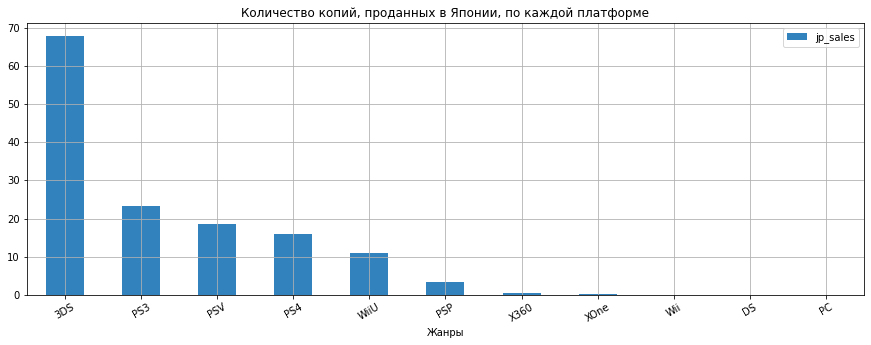

In [60]:
data_2013.pivot_table(index = 'platform', 
                 values = 'jp_sales', 
                 aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False).plot(y = 'jp_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'tab20c')

plt.xlabel('Жанры')
plt.title('Количество копий, проданных в Японии, по каждой платформе')
plt.xticks(rotation=30);

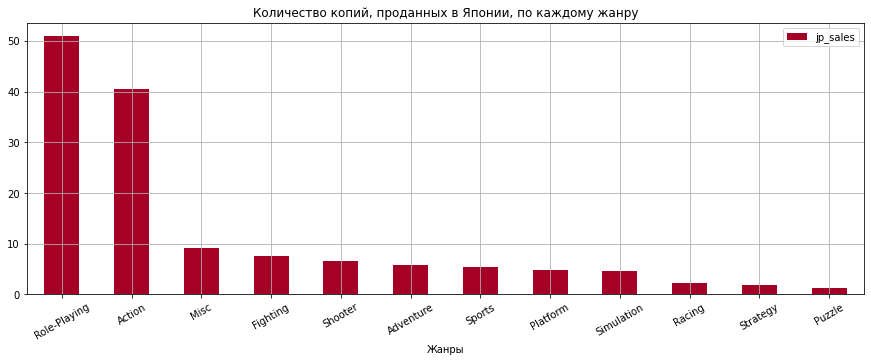

In [61]:
data_2013.pivot_table(index = 'genre', 
                 values = 'jp_sales', 
                 aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False).plot(y = 'jp_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'RdYlGn')

plt.xlabel('Жанры')
plt.title('Количество копий, проданных в Японии, по каждому жанру')
plt.xticks(rotation=30);

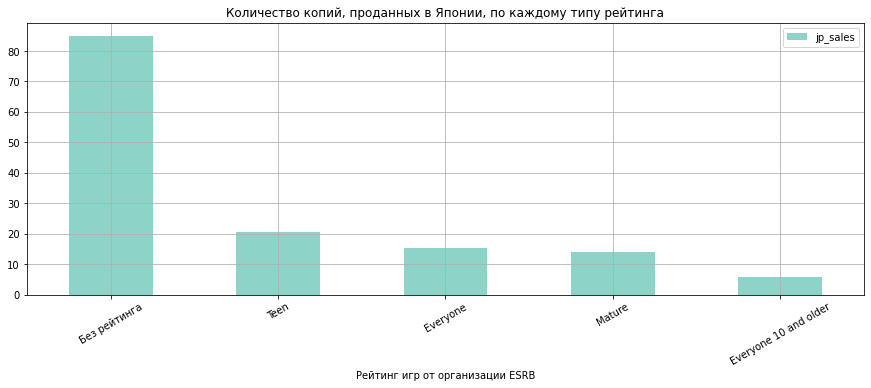

In [62]:
data_2013.pivot_table(index = 'rating', 
                 values = 'jp_sales', 
                 aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False).plot(y = 'jp_sales',
                                                                                      figsize = (15, 5),
                                                                                      kind = 'bar', 
                                                                                      grid = True,
                                                                                      cmap = 'Set3')

plt.xlabel('Рейтинг игр от организации ESRB')
plt.title('Количество копий, проданных в Японии, по каждому типу рейтинга')
plt.xticks(rotation=30);

In [63]:
data_2013.query('(rating == "Без рейтинга")&(jp_sales>0)').sort_values(by = 'jp_sales', ascending = False)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Без рейтинга,14.60
58,Monster Hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,NaN,NaN,Без рейтинга,3.44
64,Yokai Watch 2 Ganso/Honke,3DS,2014,Role-Playing,0.09,0.00,3.18,0.01,NaN,NaN,Без рейтинга,3.28
5,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Без рейтинга,11.68
62,Monster Hunter X,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,Без рейтинга,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2091,1/2 Summer +,PSP,2013,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Без рейтинга,0.01
2090,Fuuraiki 3,PSV,2015,Action,0.00,0.00,0.01,0.00,NaN,NaN,Без рейтинга,0.01
2089,DoDonPachi Saidaioujou,X360,2013,Shooter,0.00,0.00,0.01,0.00,NaN,NaN,Без рейтинга,0.01
2088,Hitotsu Tobashi Renai V,PSV,2015,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Без рейтинга,0.01


Игроки в Японии предпочитают платформу 3DS - это портативная игровая система производства Nintendo. Игр, выпущенных для этой платформы, продано в Японии более 65 млн. копий. Также в тройку популярных платформ вошли PS3 и PSV, с ~23 млн. и 19 млн. копий, соответственно.

Обычный игрок в Японии в основном играет в игры Role-Playing — жанр компьютерных игр, основанный на элементах игрового процесса традиционных настольных ролевых игр. Предпочитаемыми жанрами также являются Action и Misc (аркадные игры).

В целом, можно сказать, что портрет игрока из Японии значительно отличается от 2х предыдущих портретов. Во многом это связано с разительно отличным образом жизни японцев. Например, популярность платформы 3DS легко объясняется ее портативностью: в нее легко играть по дороге на работу или учебу.

На японском рынке наиболее явно видно предобладание игр, не имеющих рейтинга.

В целом, данная проблема может быть связана с тем, что организация ESRB определяет рейтинг для Северной Америки, в Европе аналогичную деятельность осуществляет PEGI, в Японии -  CERO

## Проверка гипотез

Поочередно проверю 2 гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные. 

Уровень значимости ('alpha') — суммарная вероятность того, что измеренное эмпирически значение окажется далеко от среднего. Задам ему значение 0.05 для всех гипотез.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сначала проверю гипотезу о рейтинге платформ Xbox One и PC.

Для этого сформулирую сначала нулевую гипотезу. Поскольку нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, в данном случае она будет следующей: "Средние пользовательские рейтинги по платформам Xbox One и PC равны".

Чтобы проверить вышеуказанную гипотезу о равенстве среднего двух совокупностей, применю метод scipy.stats.ttest_ind (array1, array2, equal_var), где:

- array1 — массив значений пользовательского рейтинга по играм на платформе Xbox One,
- array2 — массив значений пользовательского рейтинга по играм на платформе РС,
- equal_var = False, т.к. дисперсии совокупностей не равны.

Использую датафрейм 'data' и с помощью метода query сделаю выборку по году выхода игры не старше 2013 г. и по нужной платформе. Таким образом, в датафреймах 'data_xbox' и 'data_pc' будет содержаться информация по платформам Xbox One и PC, соответственно:

In [64]:
data_xbox = data.query('(year>2013)&(platform == "XOne")')
data_pc = data.query('(year>2013)&(platform == "PC")')

In [65]:
results = st.ttest_ind(data_xbox['total_sales'], data_pc['total_sales'], equal_var = False)

print('p-значение:', results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1654151818481874e-08
Отвергаем нулевую гипотезу


### Средние пользовательские рейтинги жанров Action и Sports разные

Далее проверю гипотезу о соотношении среднего пользовательского рейтинга жанров Action и Sports. Нулевая гипотеза выглядит следующим образом: "Средние пользовательские рейтинги игр жанров Action и Sports равны".

Чтобы проверить вышеуказанную гипотезу о равенстве среднего двух совокупностей, также применю метод scipy.stats.ttest_ind (array1, array2, equal_var), где:

- array1 — массив значений пользовательского рейтинга по играм жанра Action,
- array2 — массив значений пользовательского рейтинга по играм жанра Sports,
- equal_var = False, т.к. дисперсии совокупностей не равны.

Использую датафрейм 'data' и с помощью метода query сделаю выборку по году выхода игры не старше 2013 г. и по нужному жанру. Таким образом, в датафреймах 'data_action' и 'data_sports' будет содержаться информация по жанрам Action и Sports, соответственно:

In [66]:
data_action = data.query('(year>2013)&(genre == "Action")')
data_sports = data.query('(year>2013)&(genre == "Sports")')

In [67]:
results = st.ttest_ind(data_action['total_sales'], data_sports['total_sales'], equal_var = False)

print('p-значение:', results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0006168224770550474
Отвергаем нулевую гипотезу


**Вывод:**

Проверка обеих гипотез показала следующее: значение p-value ниже alpha. В данном случае есть основания отклонить нулевую теорию. Практически нет вероятности, что пользовательские рейтинги платформ Xbox One и PC одинаковы.

Стоит отметить, что p-value второй гипотезы равно 0.03, что всего на 0.02 меньше заданного значения p-value. Но все же есть основания отклонить гипотезу о том, что средние пользовательские рейтинги игр жанров Action и Sports равны.

## Общий вывод

В ходе данной исследовательской работы были проанализированы данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Если говорить о глобальных продажах игр, в целом лидирует игровая платформа PlayStation, а также Xbox. Продажи игр на вышеуказанных игровых консолях в Северной Америке, Европе и прочих странах (кроме Японии)  схожи, что может говорить о схожести вкусов игроков в данных регионах. На оценки пользователей не влияют практически никакие значения, кроме оценок критиков. аиболее прибыльные жанры игр: Action, Shooter и Sports. Наибольшую популярность в Северной Америке и Европе имееют игры с рейтингом «Mature» — «Для взрослых». В Японии игроки предпочитают платформу 3DS, а также игры не только жанров Action, но Role-Playing и Misc. На японском рынке наиболее явно видно предобладание игр, не имеющих рейтинга. 

В целом, данная проблема может быть связана с тем, что организация ESRB определяет рейтинг для Северной Америки, в Европе аналогичную деятельность осуществляет PEGI, в Японии -  CERO. 

Также были проверены 2 гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные. 

В обоих случаях были основания сделать вывод о том, что средние пользовательские рейтинги платформ Xbox One и PC не одинаковы и что средние пользовательские рейтинги жанров Action и Sports не равны.

Так как интернет-магазин "Стримчик" продает по всему миру компьютерные игры, на 2017 г. можно дать следующие рекомендации:
- для сегмента игроков из Северной Америки и Европы можно сделать упор на продвижение игр, вышедших на платформах PlayStation и Xbox, в особенности PS4, Xone, X360 и PS3. Также не стоит забывать про игры на РС, т.к. данная платформа не устаревает и всегда есть доля игроков, ее использующая. На данных платформах нужно отдать предпочтение играм жанров Action, Shooter и Sports, также игроки играют в жанры Role-Playing и Racing, хоть и реже.**
- для японского сегмента лучше продвигать игры на компактных платформах, таких как 3DS, но также популярны будут на PS3, PSV, PS4 и WiiU. Необходимо акцентировать внимание на играх жанра Role-Playing, т.к. он является самым популярным, но не стоит упускать из внимания популярный во всем мире Action, а также аркадные игры жанра Misc, шутеры и файтинги.

**Список игр для Северной Америки и Европы:**

In [68]:
data_2013.query('(platform == "PS4")or(platform == "Xone")or(platform == "X360")or(platform == "PS3")or(platform == "PC")&(genre == "Action")&(genre == "Shooter")&(genre == "Sports")').sort_values(by = 'na_sales', ascending = False)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,Mature,16.27
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,Mature,21.05
6,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,Mature,10.24
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Без рейтинга,14.63
8,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,Без рейтинга,9.18
...,...,...,...,...,...,...,...,...,...,...,...,...
1501,Winning Post 8,PS3,2014,Racing,0.00,0.00,0.05,0.00,NaN,NaN,Без рейтинга,0.05
1505,WRC 5: FIA World Rally Championship,PS4,2015,Sports,0.00,0.05,0.00,0.01,NaN,NaN,Без рейтинга,0.06
1520,Utawarerumono: Futari no Hakuoro,PS4,2016,Misc,0.00,0.00,0.05,0.00,NaN,NaN,Без рейтинга,0.05
1526,Steins;Gate 0,PS4,2015,Adventure,0.00,0.00,0.05,0.00,81.0,8.3,Mature,0.05


**Список игр для Японии:**

In [69]:
data_2013.query('(platform == "3DS")or(platform == "PS3")or(platform == "PSV")or(platform == "PS4")or(platform == "WiiU")&(genre == "Role-Playing")&(genre == "Action")&(genre == "Misc")').sort_values(by = 'jp_sales', ascending = False)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Без рейтинга,14.60
58,Monster Hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,NaN,NaN,Без рейтинга,3.44
64,Yokai Watch 2 Ganso/Honke,3DS,2014,Role-Playing,0.09,0.00,3.18,0.01,NaN,NaN,Без рейтинга,3.28
5,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Без рейтинга,11.68
62,Monster Hunter X,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,Без рейтинга,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...
1779,Kung Fu Panda: Showdown of Legendary Legends,3DS,2015,Action,0.00,0.03,0.00,0.00,NaN,NaN,Everyone 10 and older,0.03
1146,Skylanders Imaginators,PS3,2016,Platform,0.02,0.07,0.00,0.02,NaN,NaN,Everyone 10 and older,0.11
67,Madden NFL 16,PS4,2015,Sports,2.34,0.30,0.00,0.60,83.0,5.9,Everyone,3.24
1160,How to Train Your Dragon 2,PS3,2014,Adventure,0.03,0.06,0.00,0.02,NaN,NaN,Everyone 10 and older,0.11
